# The Data Science Process

This is intended to be a follow-up script for my talk entitled [Launching a Data Science Project:  Cleaning is Half the Battle](http://www.catallaxyservices.com/presentations/datascience/).  I will repeat some of the presentation in this notebook, but this notebook is not designed to replace the presentation itself.

Over the course of this notebook, we will analyze Data Professional salaries based on the [2019 Data Professionals Salary Survey](https://www.brentozar.com/archive/2019/01/the-2019-data-professional-salary-survey-results/).  We will use this data as the centerpiece of an implementation of the [Microsoft Team Data Science Process](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/overview).

The Team Data Science Process has five major steps:
1. Business Understanding
2. Data Processing
3. Modeling
4. Deployment
5. Repeat

## Business Understanding

Before we begin working, we need to understand the problem.  In our scenario, we work for Data Platform Specialists, a company dedicated to providing DBAs and other data platform professionals with valuable market knowledge. We have come into possession of a survey of data professionals and want to build insights that we can share with our client base.  Our higher-ups want us to analyze this survey and see how we can make good use of it.

During initial brainstorming, we might come up with questions like:
* How much money does a DBA make?
* Which category of DBA (junior, mid-level, senior) does this particular work?
* How can we segment the DBAs in our survey?
* Is this many hours per week weird?
* Which option should I choose as a career path? DBA? Data science? BI?

These questions could potentially be interesting, and the specific form of the question will help guide our analysis.  For example, "how much" questions typically lead to regression, whereas "which category" questions are indicative of a classification problem.  Segmentation questions where we do not know the classes beforehand is a classic example of a clustering problem, and the final two questions are anomaly detection and recommendation, respectively.

Narrowing this down with our champion and other stakeholders, we can get to the following question which we will endeavour to answer:

**How much money should we expect a data professional will make?**

This is a vague question that we will want to focus in on later, but at least it gives us a start.

## Data Processing

There are three steps to data processing:  data gathering, data cleansing, and data analysis.

### Data Gathering

In this example, we will stick to just the data professional survey. But if you want to take this further, a few additional data sources could be:

* PPP GDP per capita to normalize salaries across countries.
* A geocoding data set to visualize results on a map.
* Cost of living by ZIP code to normalize salaries within the US.
* Census information to build out data by ZIP code.
* Data from other surveys to add more to the sample.

If you are interested in extending this to include PPP GDP per capita, check out [a blog post I did based on the 2017 survey results](https://36chambers.wordpress.com/2017/01/18/analyzing-dba-salaries/).

### Data Cleansing

Here is where we begin the real work.  In the next snippet, I am going to load a series of libraries in R.  We will use each of them over the course of this notebook.  The `tidyverse` package is a series of incredibly useful libraries in R, and I can't think of doing a data science project in R without it.  The `XLConnect` package lets me read an Excel workbook easily and grab the salary data without much hassle.  The `caret` library provides some helpful tooling for working with data, including splitting out test versus training data, like we'll do below.  The `recipes` package will be useful for normalizing data later, and we will use `data.table` to get a glimpse at some of our uneven data.  We need the `devtools` package to install `keras` from GitHub.  Keras is a deep learning library which implements several neural network libraries, including TensorFlow, which we are using today.  We need to install TensorFlow on our machine.  Because this is a small data set, and because I want this to run on machines without powerful GPUs, I am using the CPU-based version of TensorFlow.  Performance should still be adequate for our purposes.

In [1]:
if(!require(tidyverse)) {
  install.packages("tidyverse", repos = "http://cran.us.r-project.org")
  library(tidyverse)
}

if(!require(XLConnect)) {
  install.packages("XLConnect", repos = "http://cran.us.r-project.org")
  library(XLConnect)
}

if(!require(caret)) {
  install.packages("caret", repos = "http://cran.us.r-project.org")
  library(caret)
}

if(!require(recipes)) {
  install.packages("recipes", repos = "http://cran.us.r-project.org")
  library(recipes)
}

if(!require(data.table)) {
  install.packages("data.table", repos = "http://cran.us.r-project.org")
  library(data.table)
}

if(!require(devtools)) {
  install.packages("devtools", repos = "http://cran.us.r-project.org")
  library(devtools)
}

if(!require(keras)) {
  devtools::install_github("rstudio/keras")
  library(keras)
  install_keras(method = "auto", conda = "auto", tensorflow = "default", extra_packages = NULL)
}

Loading required package: tidyverse
Warning message:
"package 'tidyverse' was built under R version 3.5.3"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.5.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: XLConnect
Loading required package: XLConnectJars
XLConnect 0.2-15 by Mirai Solutions GmbH [aut],
  Martin Studer [cre],
  The Apache Software Foundation [ctb, cph] (Apache POI),
  Graph Builder [ctb, cph] (Curvesapi Java library)
http://www.mirai-solutions.com
https://github.com/miraisolutions/xlconnect
Loading required package: caret
Warning message:
"package 'caret' was built under R version 3.5.2"Loading requi

Once we have the required packages loaded, we will then load the Excel workbook.  I have verified the Excel worksheet and data region are correct, so we can grab the survey from the current directory and load it into `salary_data`.

As a quick note, I fixed one data point where DatabaseServers was "022" and was causing that variable to be imported as a string.  If you grab the data set yourself and don't use the copy in my Git repo, you might want to check that before walking through this notebook.

In [2]:
wb <- XLConnect::loadWorkbook("2019_Data_Professional_Salary_Survey_Responses.xlsx")
salary_data <- XLConnect::readWorksheet(wb, sheet = "Salary Survey", region = "A4:AC6897")

We can use the `glimpse` function inside the tidyverse to get a quick idea of what our `salary_data` dataframe looks like.  In total, we have 6893 observations of 29 variables, but this covers three survey years:  2017 through 2019.  Looking at the variable names, we can see that there are some which don't matter very much (like Timestamp, which is when the user filled out the form; and Counter, which is just a 1 for each record.

In [3]:
glimpse(salary_data)

Observations: 6,893
Variables: 29
$ Survey.Year                          <dbl> 2017, 2017, 2017, 2017, 2017, ...
$ Timestamp                            <dttm> 2017-01-05 05:10:20, 2017-01-...
$ SalaryUSD                            <chr> "200000", "61515", "95000", "5...
$ Country                              <chr> "United States", "United Kingd...
$ PostalCode                           <chr> "Not Asked", "Not Asked", "Not...
$ PrimaryDatabase                      <chr> "Microsoft SQL Server", "Micro...
$ YearsWithThisDatabase                <dbl> 10, 15, 5, 6, 10, 15, 16, 4, 3...
$ OtherDatabases                       <chr> "MySQL/MariaDB", "Oracle, Post...
$ EmploymentStatus                     <chr> "Full time employee", "Full ti...
$ JobTitle                             <chr> "DBA", "DBA", "Other", "DBA", ...
$ ManageStaff                          <chr> "No", "No", "Yes", "No", "No",...
$ YearsWithThisTypeOfJob               <dbl> 5, 3, 25, 2, 10, 15, 11, 1, 2,...
$ HowManyCompanies

Our first data cleansing decision point is whether to remove certain years of data.  There are new questions in each year of the data, so we have a choice:  either ignore the questions which were asked later or remove the years of data which did not ask the relevant questions.

The most important question in 2018 was Gender, which had a noticeable impact on salaries, as you can see from the notebook which covers the 2018 salary survey.  In this survey, I will choose to keep all three years and will drop the new questions.  This lets me use all 6893 responses over the past three years.

Note that I do not need to create a new variable here, but it is usually a good idea to do so if you can afford the memory utilization, as that means you can retain an original view of the data just in case things go sideways during cleansing and analysis.

In [4]:
survey_data <- salary_data
nrow(survey_data)

[1] 6893

Looking at the survey, there are some interesting data points that we want:
* SalaryUSD (our label, that is, what we are going to try to predict)
* Country
* PrimaryDatabase
* YearsWithThisDatabase
* EmploymentStatus
* JobTitle
* ManageStaff
* YearsWithThisTypeOfJob
* OtherPeopleOnYourTeam
* DatabaseServers
* Education
* EducationIsComputerRelated
* Certifications
* HoursWorkedPerWeek
* TelecommuteDaysPerWeek
* EmploymentSector
* LookingForAnotherJob

For each of these variables, we want to see the range of options and perform any necessary cleanup.  The first thing I'd look at is the cardinality of each variable, followed by a detailed anlaysis of the smaller ones.

In [5]:
rapply(survey_data, function(x) { length(unique(x)) })

Survey.Year                            Timestamp 
                                   3                                 6891 
                           SalaryUSD                              Country 
                                1391                                   85 
                          PostalCode                      PrimaryDatabase 
                                2305                                   15 
               YearsWithThisDatabase                       OtherDatabases 
                                  42                                 1340 
                    EmploymentStatus                             JobTitle 
                                   5                                   23 
                         ManageStaff               YearsWithThisTypeOfJob 
                                   2                                   41 
                    HowManyCompanies                OtherPeopleOnYourTeam 
                                   7                                    7 
             CompanyEmployeesOverall                      DatabaseServers 
                                   7                                  250 
                           Education           EducationIsComputerRelated 
                                   5                                    3 
                      Certifications                   HoursWorkedPerWeek 
                                   3                                   57 
              TelecommuteDaysPerWeek PopulationOfLargestCityWithin20Miles 
                                   6                                    6 
                    EmploymentSector                 LookingForAnotherJob 
                                   7                                    3 
                 CareerPlansThisYear                               Gender 
                                   6                                   24 
                      OtherJobDuties                KindsOfTasksPerformed 
                                 556                                  212 
                             Counter 
                                   1

In [6]:
unique(survey_data$Country)

[1] "United States"         "United Kingdom"        "Germany"              
 [4] "France"                "Netherlands"           "Belgium"              
 [7] "Canada"                "Poland"                "Ukraine"              
[10] "Australia"             "India"                 "Portugal"             
[13] "South Africa"          "Greece"                "Israel"               
[16] "Sweden"                "Spain"                 "Norway"               
[19] "Jersey"                "Argentina"             "Russia"               
[22] "Switzerland"           "Denmark"               "Ireland"              
[25] "Italy"                 "Mexico"                "Albania"              
[28] "Brazil"                "Romania"               "Uganda"               
[31] "Slovenia"              "Bulgaria"              "Turkey"               
[34] "Lithuania"             "New Zealand"           "Czech Republic"       
[37] "Croatia"               "Finland"               "Austria"              
[40] "Hungary"               "El Salvador"           "Bolivia"              
[43] "Vietnam"               "China"                 "Luxembourg"           
[46] "Iceland"               "Serbia and Montenegro" "Jamaica"              
[49] "Moldova"               "Saudi Arabia"          "Paraguay"             
[52] "Guernsey"              "Hong Kong"             "Venezuela"            
[55] "Philippines"           "Malaysia"              "Macedonia"            
[58] "Bermuda"               "Ecuador"               "Nicaragua"            
[61] "Puerto Rico"           "Peru"                  "Singapore"            
[64] "Kenya"                 "Syria"                 "Colombia"             
[67] "United Arab Emirates"  "Costa Rica"            "Cayman Islands"       
[70] "Indonesia"             "Bahrain"               "Thailand"             
[73] "Slovakia"              "Pakistan"              "Malta"                
[76] "Jordan"                "Belarus"               "Estonia"              
[79] "Latvia"                "Nepal"                 "Ghana"                
[82] "Dominican Republic"    "Uruguay"               "Guatemala"            
[85] "Taiwan"

In [7]:
unique(survey_data$EmploymentStatus)

[1] "Full time employee"                                               
[2] "Full time employee of a consulting/contracting company"           
[3] "Independent or freelancer or company owner"                       
[4] "Independent consultant, contractor, freelancer,  or company owner"
[5] "Part time"

We can use the `setDT` function on `data.table` to see just how many records we have for each level of a particular factor.  For example, we can see the different entries for PrimaryDatabase and EmploymentSector below.  Both of these are troublesome for our modeling because they both have a number of levels with 1-2 entries.  This makes it likely that we will fail to collect a relevant record in our training data set, and that will mess up our model later.  

PrimaryDatabase is also troublesome because it skews so heavily toward SQL Server that there's more noise than signal to it.  Because there are so many platforms with 10 or fewer entries and about 94% of entrants selected SQL Server, we'll throw it out.

In [8]:
data.table::setDT(survey_data)[, .N, keyby=PrimaryDatabase]

PrimaryDatabase,N
Amazon RDS (any flavor),13
Azure SQL DB,24
Cassandra,2
DB2,16
Elasticsearch,2
Microsoft Access,15
Microsoft SQL Server,6461
MongoDB,6
MySQL/MariaDB,29
Oracle,215


There are only nine students in this survey.  That's not enough data points to draw a meaningful conclusion, so I will throw those nine out.

In [9]:
data.table::setDT(survey_data)[, .N, keyby=EmploymentSector]

EmploymentSector,N
"Education (K-12, college, university)",151
Federal government,181
Local government,276
Non-profit,217
Private business,5734
State/province government,325
Student,9


Most of these columns came from dropdown lists, so they're already fairly clean.  But there are some exceptions to the rule.  They are:
* SalaryUSD
* YearsWithThisDatabase
* YearsWithThisTypeOfJob
* DatabaseServers
* HoursWorkedPerWeek

All of these were text fields, and whenever a user gets to enter text, you can assume that something will go wrong.  For example:

In [10]:
survey_data %>%
  distinct(YearsWithThisDatabase) %>%
  arrange(desc(YearsWithThisDatabase)) %>%
  top_n(10, YearsWithThisDatabase)

YearsWithThisDatabase
53716
30331
2011
2008
2004
2003
2000
1050
38
32


Someone with 53,716 years working with their primary database of choice?  That's commitment!  You can also see a couple of people who clearly put in the year they started rather than the number of years working with it, and someone who maybe meant 10 years?  But who knows, people type in weird stuff.

Anyhow, let's see how much those people with at least 10 thousand years of experience make:

In [11]:
survey_data %>%
  filter(YearsWithThisDatabase > 10000)

Survey.Year,Timestamp,SalaryUSD,Country,PostalCode,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,...,HoursWorkedPerWeek,TelecommuteDaysPerWeek,PopulationOfLargestCityWithin20Miles,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed,Counter
2018,2017-12-12 19:07:35,95000,United States,NA,Microsoft SQL Server,53716,Microsoft SQL Server,Full time employee of a consulting/contracting company,Engineer,...,45,"None, or less than 1 day per week",Not Asked,Private business,"Yes, but only passively (just curious)","Stay with the same employer, same role",Female,"DBA (Production Focus - build & troubleshoot servers, HA/DR)","Manual tasks, On-call as part of a rotation, Projects",1
2018,2017-12-18 20:41:48,"98,000",United States,30071,Microsoft SQL Server,30331,Microsoft SQL Server,Full time employee,Developer: T-SQL,...,50,1,Not Asked,Private business,"Yes, but only passively (just curious)","Stay with the same employer, same role",Female,NA,"Build scripts & automation tools, Projects, R&D",1


That's pretty sad, considering their millennia of work experience.  $95-98K isn't even that great a number.

Looking at years of experience with their current job roles, people tend to be more reasonable:

In [12]:
survey_data %>%
  distinct(YearsWithThisTypeOfJob) %>%
  arrange(desc(YearsWithThisTypeOfJob)) %>%
  top_n(10, YearsWithThisTypeOfJob)

YearsWithThisTypeOfJob
40
39
38
37
36
35
34
33
32
31


Now let's look at hours per week:

In [13]:
survey_data %>%
  distinct(HoursWorkedPerWeek) %>%
  arrange(desc(HoursWorkedPerWeek)) %>%
  top_n(10, HoursWorkedPerWeek)

HoursWorkedPerWeek
200
160
150
100
93
90
85
82
80
78


To the person who works 200 hours per week:  find a new job.  Your ability to pack more than 7\*24 hours of work into 7 days is too good to waste on a job making just $120K per year.

In [14]:
survey_data %>%
  filter(HoursWorkedPerWeek >= 168) %>%
  arrange(desc(HoursWorkedPerWeek))

Survey.Year,Timestamp,SalaryUSD,Country,PostalCode,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,...,HoursWorkedPerWeek,TelecommuteDaysPerWeek,PopulationOfLargestCityWithin20Miles,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed,Counter
2018,2018-01-03 10:28:45,"120,000",Israel,NA,Microsoft SQL Server,5,Microsoft SQL Server,Full time employee,Manager,...,200,"None, or less than 1 day per week",Not Asked,Private business,No,"Stay with the same employer, same role",Male,"Architect, DBA (Production Focus - build & troubleshoot servers, HA/DR), DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers), Developer: Business Intelligence (SSRS, PowerBI, etc), Developer: T-SQL, Manager","Build scripts & automation tools, Meetings & management, On-call 24/7/365, Projects, R&D",1


There are only twenty countries with at least 30 data points.  This means that we won't get a great amount of information from cross-country comparisons outside of the sample.  Frankly, I might want to limit this to just the US, UK, Canada, and maybe Australia and India, as the rest are marginal, but for this survey analysis, I'll keep the remainder.

In [15]:
survey_data %>%
  group_by(Country) %>%
  summarize(n = n()) %>%
  filter(n >= 30)

Country,n
Australia,185
Belgium,30
Canada,244
Denmark,52
France,34
Germany,97
India,112
Ireland,37
Italy,32
Netherlands,82


#### Building Our Cleaned-Up Data Set

Now that we've performed some basic analysis, we will clean up the data set.  I'm doing most of the cleanup in a single operation, but I do have some comment notes here, particularly around the oddities with SalaryUSD.  The SalaryUSD column has a few problems:
* Some people put in pennies, which aren't really that important at the level we're discussing.  I want to strip them out.
* Some people put in delimiters like commas or decimal points (which act as commas in countries like Germany).  I want to strip them out, particularly because the decimal point might interfere with my analysis, turning 100.000 to \\$100 instead of \\$100K.
* Some people included the dollar sign, so remove that, as well as any spaces.

It's not a perfect regex, but it did seem to fix the problems in this data set at least.

In [16]:
valid_countries <- survey_data %>%
                    group_by(Country) %>%
                    summarize(n = n()) %>%
                    filter(n >= 30)

# Data cleanup
survey_data <- salary_data %>%
  filter(HoursWorkedPerWeek < 200) %>%
  # There were only nine students in the survey, so we will exclude them here.
  filter(EmploymentSector != "Student") %>%
  inner_join(valid_countries, by="Country") %>%
  mutate(
    SalaryUSD = stringr::str_replace_all(SalaryUSD, "\\$", "") %>%
      stringr::str_replace_all(., ",", "") %>%
      stringr::str_replace_all(., " ", "") %>%
      # Some people put in pennies.  Let's remove anything with a decimal point and then two numbers.
      stringr::str_replace_all(., stringr::regex("\\.[0-9]{2}$"), "") %>%
      # Now any decimal points remaining are formatting characters.
      stringr::str_replace_all(., "\\.", "") %>%
      as.numeric(.),
    # Some people have entered bad values here, so set them to the median.
    YearsWithThisDatabase = case_when(
      (YearsWithThisDatabase > 32) ~ median(YearsWithThisDatabase),
      TRUE ~ YearsWithThisDatabase
    ),
    # Some people apparently entered number of databases rather than number of servers.
    DatabaseServers = case_when(
      (DatabaseServers >= 5000) ~ median(DatabaseServers),
      TRUE ~ DatabaseServers
    ),
    EmploymentStatus = as.factor(EmploymentStatus),
    JobTitle = as.factor(JobTitle),
    ManageStaff = as.factor(ManageStaff),
    OtherPeopleOnYourTeam = as.factor(OtherPeopleOnYourTeam),
    Education = as.factor(Education),
    EducationIsComputerRelated = as.factor(EducationIsComputerRelated),
    Certifications = as.factor(Certifications),
    TelecommuteDaysPerWeek = as.factor(TelecommuteDaysPerWeek),
    EmploymentSector = as.factor(EmploymentSector),
    LookingForAnotherJob = as.factor(LookingForAnotherJob)
  ) 

Now we can pare out variables we don't need.  In many cases, this is information which was not asked in 2017, so we choose to elimintate them to keep the ~3000 survey responses in place.

Some of these eliminated columns, like postal code, are interesting but we just don't have enough data for it to make sense.  Others, like Kinds of Tasks Performed or Other Job Duties, have too many varieties for us to make much sense with a first pass.  They might be interesting in a subsequent analysis, though.

In [17]:
survey_data <- survey_data %>%
  # One person had a salary of zero.  That's just not right.
  filter(SalaryUSD > 0) %>%
  select(-Survey.Year, -Timestamp, -PostalCode, -PrimaryDatabase, -OtherDatabases, -HowManyCompanies,
         -CompanyEmployeesOverall, -PopulationOfLargestCityWithin20Miles, -CareerPlansThisYear, -Gender,
         -OtherJobDuties, -KindsOfTasksPerformed, -Counter, -n)

Now that we have our salary data fixed, we can finally look at outliers.  I'd consider a salary of \\$500K a year to be a bit weird for this field.  It's not impossible, but I am a little suspicious.  I am very suspicious of the part-timer making \\$1.375 million, the federal employee making \\$1 million, or the New Zealander making \\$630K at a non-profit.

I'm kind of taking a risk by removing these, 

In [18]:
survey_data %>%
  filter(SalaryUSD > 500000) %>%
  arrange(desc(SalaryUSD))

SalaryUSD,Country,YearsWithThisDatabase,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,EducationIsComputerRelated,Certifications,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
1450000,United States,12,Full time employee,Analyst,No,12,3,120,Bachelors (4 years),Yes,"Yes, and they're currently valid",42,"None, or less than 1 day per week",Private business,No
1450000,United States,20,Full time employee,DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers),Yes,10,None,10,Bachelors (4 years),Yes,"Yes, but they expired",45,5 or more,Private business,"Yes, but only passively (just curious)"
1375000,United States,8,Part time,"Developer: Business Intelligence (SSRS, PowerBI, etc)",Yes,18,None,1,Masters,No,"No, I never have",32,1,Private business,No
1000000,United States,15,Full time employee,Manager,Yes,20,None,15,None (no degree completed),No,"No, I never have",60,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"
1000000,United States,10,"Independent consultant, contractor, freelancer, or company owner","DBA (Production Focus - build & troubleshoot servers, HA/DR)",Yes,3,None,1000,Doctorate/PhD,Yes,"Yes, and they're currently valid",80,5 or more,Federal government,No
960000,United States,10,Full time employee,DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers),Yes,8,1,6,Associates (2 years),No,"Yes, but they expired",40,5 or more,Private business,No
832031,United Kingdom,11,Full time employee,"DBA (Production Focus - build & troubleshoot servers, HA/DR)",No,5,3,30,None (no degree completed),N/A,"Yes, but they expired",40,1,Private business,"Yes, but only passively (just curious)"
800000,Germany,15,Full time employee of a consulting/contracting company,"DBA (Production Focus - build & troubleshoot servers, HA/DR)",Yes,17,2,80,None (no degree completed),N/A,"Yes, but they expired",40,3,Private business,"Yes, but only passively (just curious)"
785000,United States,20,Full time employee,DBA,No,8,None,25,Bachelors (4 years),Yes,"No, I never have",35,"None, or less than 1 day per week",Local government,"Yes, but only passively (just curious)"
750000,United States,3,Full time employee,DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers),No,3,None,90,Associates (2 years),No,"No, I never have",45,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"


On the other side, there are 24 people who say they earned less than $5K a year.  Those also seem wrong.  Some of them look like dollars per  hour, and maybe some are monthly salary.  I'm going to strip those out.

In [19]:
survey_data %>%
  filter(SalaryUSD < 5000) %>%
  arrange(desc(SalaryUSD))

SalaryUSD,Country,YearsWithThisDatabase,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,EducationIsComputerRelated,Certifications,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
4423,India,2,Full time employee of a consulting/contracting company,DBA,Yes,2,More than 5,98,Bachelors (4 years),Yes,"No, I never have",54,"None, or less than 1 day per week",Private business,No
4420,India,1,Full time employee,DBA,No,1,2,700,Bachelors (4 years),Yes,"No, I never have",30,"None, or less than 1 day per week",Private business,"Yes, actively looking for something else"
4118,India,3,Full time employee,DBA,No,2,4,50,Bachelors (4 years),Yes,"No, I never have",48,"None, or less than 1 day per week",Private business,"Yes, actively looking for something else"
4000,South Africa,21,Full time employee,Developer: T-SQL,No,3,1,4,None (no degree completed),N/A,"No, I never have",55,5 or more,Private business,"Yes, actively looking for something else"
3900,India,2,Full time employee,DBA,No,2,2,30,Bachelors (4 years),Yes,"No, I never have",45,"None, or less than 1 day per week",Private business,"Yes, actively looking for something else"
3580,Romania,6,Full time employee,"DBA (Development Focus - tunes queries, indexes, does deployments)",No,2,2,50,Masters,Yes,"No, I never have",40,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"
3000,India,3,Full time employee,Developer: T-SQL,No,5,More than 5,5,None (no degree completed),No,"Yes, but they expired",40,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"
2246,India,2,Full time employee,"Developer: Business Intelligence (SSRS, PowerBI, etc)",Yes,2,4,2,Masters,Yes,"No, I never have",40,"None, or less than 1 day per week",Private business,"Yes, actively looking for something else"
2000,Poland,7,Full time employee,DBA,No,1,4,15,Masters,Yes,"Yes, but they expired",40,5 or more,Private business,No
2000,South Africa,20,Full time employee,DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers),No,4,None,50,Associates (2 years),Yes,"Yes, and they're currently valid",50,2,Private business,"Yes, but only passively (just curious)"


In [20]:
survey_data <- filter(survey_data, SalaryUSD >= 5000 & SalaryUSD <= 500000)

### Data Analysis

We did some of the data analysis up above.  We can do additional visualization and correlation studies.  For example, let's look at a quick distribution of salaries after our cleanup work:

In [21]:
summary(survey_data$SalaryUSD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5000   68000   92000   94198  115000  500000 

We can also build a histogram pretty easily using the `ggplot2` library.  This shows the big clump of database professionals earning beween \$70K and \$115K per year.  This salary distribution does skew right a bit, as you can see.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


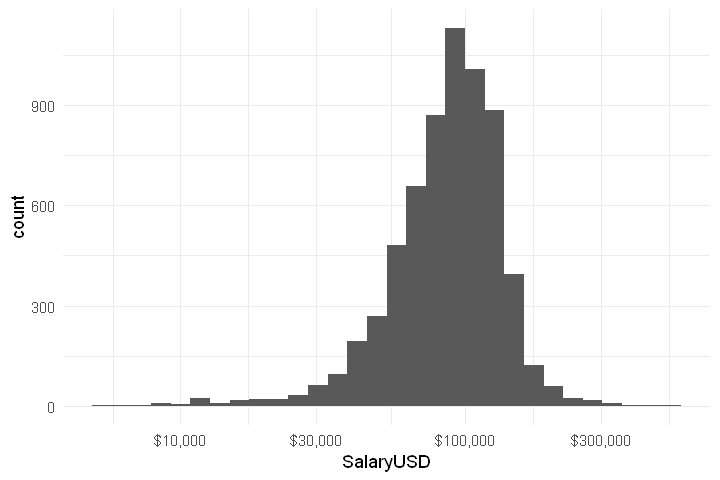

In [22]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = survey_data, mapping = aes(x = SalaryUSD)) +
  geom_histogram() +
  theme_minimal() +
  scale_x_log10(label = scales::dollar)

We can also break this down to look by primary job title, though I'll limit to a couple of summaries instead of showing a full picture.

In [23]:
survey_data %>% filter(JobTitle == "Data Scientist") %>% select(SalaryUSD) %>% summary(.)

   SalaryUSD     
 Min.   : 45000  
 1st Qu.: 73000  
 Median :116000  
 Mean   :112222  
 3rd Qu.:138500  
 Max.   :225000  

In [24]:
survey_data %>% filter(JobTitle == "Developer: App code (C#, JS, etc)") %>% select(SalaryUSD) %>% summary(.)

   SalaryUSD     
 Min.   : 12600  
 1st Qu.: 60813  
 Median : 83000  
 Mean   : 84158  
 3rd Qu.:104000  
 Max.   :194000  

In [25]:
survey_data %>% filter(JobTitle == "Developer: T-SQL") %>% select(SalaryUSD) %>% summary(.)

   SalaryUSD     
 Min.   :  6200  
 1st Qu.: 65000  
 Median : 86000  
 Mean   : 88678  
 3rd Qu.:110000  
 Max.   :500000  

This fit pretty well to my biases, with Data Scientist salaries perhaps a bit lower than I'd expect.

## Modeling

Because our question is a "how much?" question, we want to use regression to solve the problem.  The most common form of regression that you'll see in demonstrations is linear regression, because it is easy to teach and easy to understand.  In today's demo, however, we're going to build a neural network with Keras.  Although our demo is in R, Keras actually uses Python on the back end to run TensorFlow.  There are other libraries out there which can run neural networks strictly within R (for example, Microsoft Machine Learning's R implemenation has the `RxNeuralNet()` function), but we will use Keras in this demo because it is a popular library.

Now that we have an algorithm and implementation in mind, let's split the data out into training and test subsets.  I want to use Country as the partition variable because I want to ensure that we retain some data from each country in the test set.  To make this split, I am using the `createDataPartition()` function in `caret`.  I'll then split out the data into training and test data.

In [26]:
trainIndex <- caret::createDataPartition(survey_data$Country, p = 0.7, list = FALSE, times = 1)
train_data <- survey_data[trainIndex,]
test_data <- survey_data[-trainIndex,]
nrow(train_data)
nrow(test_data)

[1] 4515

[1] 1925

Once I have this data split, I want to perform some operations on the training data.  Specifically, I want to do the following:
* One-Hot Encode the categorical data
* Mean-center the data, so that the mean of each numeric value is 0
* Scale the data, so that the standard deviation of each value is 1

The bottom two are called **normalizing** the data.  This is a valuable technique when dealing with many algorithms, including neural networks, as it helps with optimizing gradient descent problems.

In order to perform all of these operations, I will create a `recipe`, using the `recipes` package.

**NOTE:**  It turns out that normalizing the features results in a slightly worse outcome in this case, so I'm actually going to avoid that.  You can uncomment the two sections and run it yourself if you want to try.  In some problems, normalization is the right answer; in others, it's better without normalization.

In [27]:
rec_obj <- recipes::recipe(SalaryUSD ~ ., data = train_data) %>%       # Build out a set of rules we want to follow (a recipe)
  step_dummy(all_nominal(), -all_outcomes()) %>%              # One-hot encode categorical data
  #step_center(all_predictors(), -all_outcomes()) %>%          # Mean-center the data
  #step_scale(all_predictors(), -all_outcomes()) %>%           # Scale the data
  prep(data = train_data)

rec_obj

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         15

Training data contained 4515 data points and no missing data.

Operations:

Dummy variables from Country, EmploymentStatus, JobTitle, ... [trained]

Now we can `bake` our data based on the recipe above.  Note that I performed all of these operations only on the **training** data.  If we normalize the training + test data, our optimization function can get a sneak peek at the distribution of the test data based on what is in the training set, and that will bias our result.

After building up the `x_` series of data sets, I'll build vectors which contain the salaries for the training and test data.  I need to make sure to remove the SalaryUSD variable; we don't want to make that available to the trainer as an independent variable!

In [28]:
x_train_data <- recipes::bake(rec_obj, new_data = train_data)
x_test_data <- recipes::bake(rec_obj, new_data = test_data)
y_train_vec <- pull(x_train_data, SalaryUSD)
y_test_vec  <- pull(x_test_data, SalaryUSD)
# Remove the SalaryUSD variable.
x_train_data <- x_train_data[,-1]
x_test_data <- x_test_data[,-1]

At this point, I want to build the Keras model.  I'm creating a `build_model` function in case I want to run this over and over. In a real-life scenario, I would perform various optimizations, do cross-validation, etc.  In this scenario, however, I am just going to run one time against the full training data set, and then evaluate it against the test data set.

Inside the function, we start by declaring a Keras model.  Then, I add three layers to the model.  The first layer is a dense (fully-connected) layer which accepts the training data as inputs and uses the Rectified Linear Unit (ReLU) activation mechanism.  This is a decent first guess for activation mechanisms.  We then have a dropout layer, which reduces the risk of overfitting on the training data.  Finally, I have a dense layer for my output, which will give me the salary.

I compile the model using the `RMSProp` optimizer.  This is a good default optimizer for neural networks, although you might try `Adagrad`, `Adam`, or `AdaMax` as well.  Our loss function is Mean Squared Error, which is good for dealing with finding the error in a regression.  Finally, I'm interested in the Mean Absolute Error--that is, the dollar amount difference between our function's prediction and the actual salary.  The closer to \$0 this is, the better.

In [29]:
build_model <- function() {
  model <- keras_model_sequential() %>%
    layer_dense(units = 256, input_shape = c(ncol(x_train_data)), activation = "relu") %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 1, activation = "linear") # No activation --> linear layer

  # RMSProp is a nice default optimizer for a neural network.
  # Mean Squared Error is a classic loss function for dealing with regression-style problems, whether with a neural network or otherwise.
  # Mean Average Error gives us a metric which directly translates to the number of dollars we are off with our predictions.
  model %>% compile(
    optimizer = "rmsprop",
    loss = "mse",
    metrics = c("mae")
  )
}

Building out this model can take some time, so be patient.

In [30]:
model <- build_model()
model %>% fit(as.matrix(x_train_data), y_train_vec, epochs = 100, batch_size = 16, verbose = 0)
result <- model %>% evaluate(as.matrix(x_test_data), y_test_vec)
result

$loss
[1] 768600972

$mean_absolute_error
[1] 17999.32

What this tells us is that, after generating our model, we are an average of \\$mean_absolute_error dollars off from reality.  In my case, that was just under \\$19K.  That's not an awful amount off.  In fact, it's an alright start, though I wouldn't trust this model as-is for for my negotiations.  With a few other enhancements, we might see that number drop a bit and start getting into the trustworthy territory.

With a real data science project, I would dig further, seeing if there were better algorithms available, cross-validating the training set, etc.  As-is, this result isn't good enough for a production scenario, but we can pretend that it is.

## Quick Validation And Testing

Now let's test scenarios.  I will use three actual times in my career:  when I started as a SQL Server developer, when I was ready to move on from a job in 2013, and when I became a manager of a predictive analytics team.  As a twist, we'll also include the third scenario, but in a hypothetical world where I moved to Canada.

In [31]:
test_cases <- test_data[1:4, ]

test_cases$SalaryUSD = c(1,2,3,4)
test_cases$Country = c("United States", "United States", "United States", "Canada")
test_cases$YearsWithThisDatabase = c(0, 5, 11, 11)
test_cases$EmploymentStatus = c("Full time employee", "Full time employee", "Full time employee", "Full time employee")
test_cases$JobTitle = c("Developer: App code (C#, JS, etc)", "DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers)", "Manager", "Manager")
test_cases$ManageStaff = c("No", "No", "Yes", "Yes")
test_cases$YearsWithThisTypeOfJob = c(0, 5, 0, 0)
test_cases$OtherPeopleOnYourTeam = c("5", "None", "2", "2")
test_cases$DatabaseServers = c(8, 12, 150, 150)
test_cases$Education = c("Bachelors (4 years)", "Masters", "Masters", "Masters")
test_cases$EducationIsComputerRelated = c("Yes", "Yes", "Yes", "Yes")
test_cases$Certifications = c("No, I never have", "Yes, and they're currently valid", "Yes, but they expired", "Yes, but they expired")
test_cases$HoursWorkedPerWeek = c(40, 40, 40, 40)
test_cases$TelecommuteDaysPerWeek = c("None, or less than 1 day per week", "None, or less than 1 day per week", "None, or less than 1 day per week", "None, or less than 1 day per week")
test_cases$EmploymentSector = c("State/province government", "State/province government", "Private business", "Private business")
test_cases$LookingForAnotherJob = c("No", "Yes, actively looking for something else", "No", "No")

In [32]:
x_test_cases <- recipes::bake(rec_obj, new_data = test_cases)
x_test_cases <- x_test_cases %>% select(-SalaryUSD)

Warning message:
" There were 10 columns that were factors when the recipe was prepped:
 'EmploymentStatus', 'JobTitle', 'ManageStaff', 'OtherPeopleOnYourTeam', 'Education', 'EducationIsComputerRelated', 'Certifications', 'TelecommuteDaysPerWeek', 'EmploymentSector', 'LookingForAnotherJob'.
 This may cause errors when processing new data."

In [33]:
model %>% predict(as.matrix(x_test_cases))

57922.67
71380.12
122336.76
90345.52


The first and third predictions were somewhere in the ballpark, though none was spot on.  The second prediction was quite a bit off.  The Canadian rate is interesting considering the exchange rate for this time span was about 75-78 US cents per Canadian dollar, and the Canadian rate is about 75%.

## Deployment

During the deployment phase, we will need to take our web service's inputs and transform them into the same shape as our training and test data.  We would then run the set and output our SalaryUSD prediction as the result.

I'm leaving the details of that as an exercise (because there are so many variables around deployment, including how you will fit it into your normal infrastructure), but a few thoughts:

1. As mentioned in the scenario, we're going to run a lot of one-off predictions rather than taking a batch of inputs, we want to optimize this for speed.  We could probably make this an asynchronous call so that when one of our users changes a detail like number of years working at the job, we can update our salary estimate.
2. This would probably be a good use case for SQL Server Machine Learning Services:  if we save all of the profile data in the database, we can pass those results straight to ML Services and perform the transformation and prediction in R.  If we go this route, we'd return the results as a SQL Server result set, which is easy for most developers to handle.
3. Another option would be to rewrite this in Python, as we're using Python under the covers anyhow.  Then we could use a web service framework like Flask to build a simple API.  If you go that route, you might want to stand up a production-grade service like Gunicorn and use Nginx as the front door to handle traffic and load balancing.

## Repeat The Process

From here, we would collect data on actual predictions.  We saw the test set's Mean Absolute Error, but an even more valuable measure is the Mean Absolute Error of actual data.  We'd need to ask people what their actual salaries are to know for sure, but we could feed these back into the training data and keep training our model.  One of the nice things about using a neural network like this is that we can continuously train the model based on our newly-gathered data.

Next, we would want to follow up with our stakeholders.  If they're happy with this result, we could probably look at other uses for the data source, such as cleaning up and including postal code, or integrating with a service to get more granular information on salary in certain parts of larger countries like the US and Canada.